In [187]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import keras
import tensorflow
from keras import Sequential
from keras.layers import Dense

In [188]:
df = pd.read_csv('COVID19_open_line_list.csv')

In [189]:
df = df[pd.notnull(df['age'])]
df = df[pd.notnull(df['sex'])]
df = df[pd.notnull(df['country'])]
df = df[pd.notnull(df['lives_in_Wuhan'])]
df.drop(columns = ['city','province','latitude','longitude','geo_resolution','additional_information','source','sequence_available','outcome','notes_for_discussion','location','admin3','admin2','admin1','country_new','admin_id','data_moderator_initials'])

,ID,age,sex,country,wuhan(0)_not_wuhan(1),date_onset_symptoms,date_admission_hospital,date_confirmation,symptoms,lives_in_Wuhan,travel_history_dates,travel_history_location,reported_market_exposure,chronic_disease_binary,chronic_disease,date_death_or_discharge
258,11545,70-79,male,Japan,1,19.02.2020,20.02.2020,21.02.2020,NaN,no,NaN,NaN,NaN,NaN,NaN,NaN
276,1771,60-69,male,Japan,1,14.01.2020,25.01.2020,28.01.2020,"chills, cough, joint pain",no,NaN,NaN,no,NaN,NaN,NaN
277,2594,60-69,male,Australia,1,23.01.2020,NaN,29.01.2020,NaN,no,NaN,Wuhan,NaN,NaN,NaN,NaN
278,3021,60-69,male,United States,1,NaN,NaN,30.01.2020,NaN,no,NaN,NaN,NaN,NaN,NaN,NaN
287,11547,60-69,male,Japan,1,06.02.2020,21.02.2020,21.02.2020,NaN,no,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1575,5108,5,female,China,1,22.01.2020,27.01.2020,02.02.2020,NaN,no,NaN,NaN,NaN,NaN,NaN,NaN
1577,9191,4,female,China,1,NaN,NaN,08.02.2020,NaN,no,25.01.2020 -,Wuhan City,NaN,NaN,NaN,NaN
1579,2362,3,female,China,1,27.01.2020,27.01.2020,29.01.2020,NaN,no,21.01.2020,Wuhan,NaN,NaN,NaN,NaN
1580,163,2,female,China,1,22.01.2020,23.01.2020,24.01.2020,"fever, sneeze",yes,21.01.2020,Wuhan,NaN,NaN,NaN,NaN


In [190]:
test = df.iloc[:,13]
symptom_set = set()
for row in list(test):
    row = str(row)
    l = row.split(",")
    for symp in l:
        symp = symp.strip()
        if symp == "nan":
            continue
        elif symp not in symptom_set:
            if "fever" in symp or "Fever" in symp:
                symptom_set.add("fever")
            else:
                symptom_set.add(symp)
        else:
            continue
print(symptom_set)

{'pneumonitis', 'runny nose', 'muscular soreness', 'rigor', 'physical discomfort', 'vomiting', 'myalgias', 'myalgia', 'soreness', 'lesions on chest radiographs', 'lack of energy', 'pleural effusion', 'coughing', 'diarrhea', 'feeling ill', 'sneeze', 'other symptoms', 'pleuritic chest pain', 'chest tightness', 'pharyngeal discomfort', 'muscle ache', 'fatigue', 'weak', 'sore throat', 'muscle soreness', 'severe dyspnea', 'pharynx', 'headache', 'respiratory symptoms', 'expectoration', 'nasal congestion', 'sneezing', 'nausea', 'cough', 'muscular stiffness', 'chest distress', 'chest pain', 'rhinorrhoea', 'pharyngalgia', 'sore limbs', 'shortness of breath', 'sore muscle', 'dizziness', 'eye irritation', 'pneumonia', 'discomfort', 'fever', 'dyspnea', 'anhelation', 'eventually showed acute left heart failure and acute coronary syndrome', 'muscle aches', 'joint pain', 'flu-like symptoms', 'muscle pain', 'weakness', 'conjunctivitis', 'asymptomatic', 'dry cough', 'diarrhoea', 'sputum', 'chills', 'sw

In [191]:
test = df.iloc[:,5]
country_dict = dict()
count = 0
for row in list(test):
    row = str(row)
    if row in country_dict:
        continue
    else:
        country_dict[row] = count
        count+= 1
print(country_dict)

{'Japan': 0, 'Australia': 1, 'United States': 2, 'Canada': 3, 'Sweden': 4, 'Germany': 5, 'Finland': 6, 'China': 7, 'Singapore': 8, 'Thailand': 9, 'Vietnam': 10, 'South Korea': 11, 'Spain': 12, 'Cambodia': 13, 'North Macedonia': 14, 'Georgia': 15, 'France': 16, 'Philippines': 17, 'Malaysia': 18, 'Greece': 19, 'Afghanistan': 20, 'Estonia': 21, 'Nepal': 22, 'Italy': 23, 'Croatia': 24, 'Pakistan': 25, 'Romania': 26}


In [193]:
cleanedData = []
count = 0
Count = 0
for index,row in df.iterrows():
    cur = []
    Count += 1
    # Clean the age column
    if str(row["age"]).isnumeric():
        #cur.append(int(row["age"]) // 10)
        cur += [0] * (int(row["age"]) // 10) + [1] + (9 - (int(row["age"]) // 10)) * [0]
    else:
        if "-" in row["age"]:
            loc = row["age"].index("-")
            #cur.append(int(row["age"][:loc]) // 10)
            cur += [0] * (int(row["age"][:loc]) // 10) + [1] + (9 - (int(row["age"][:loc]) // 10)) * [0]
        else:
            #cur.append(int(float(row["age"]) // 10))
            cur += [0] * ((int(float(row["age"]))) // 10) + [1] + (9 - ((int(float(row["age"]))) // 10)) * [0]
            
    
    # Clean the sex column
    if row["sex"] == "male":
        cur += [1,0]
    else:
        cur += [0,1]
    # Clean the country
    #cur.append(country_dict[str(row["country"])])
    cur += [0]*(country_dict[str(row["country"])]) + [1] + (26 -country_dict[str(row["country"])]) * [0]
    
    # Clean the Wuhan column, check whether they are citizens in Wuhan, 1 means not Wuhan
    cur.append(row["wuhan(0)_not_wuhan(1)"])
    # Clean the sympton date
    
    # Clean the sympton
    temp = str(row["symptoms"]).lower()
    # fever, cough, pneumonitis, fatigue
    # Fever- related
    if "fever" in temp or "headache" in temp:
        cur.append(1)
    else:
        cur.append(0)
    # Cough related
    if "cou" in temp or "throa" in temp or "dry" in temp or "pharyngeal" in temp or "expectoration" in temp or "flu" in temp:
        cur.append(1)
    else:
        cur.append(0)
    # Cold related
    if "chill" in temp or "nose" in temp or "nasal" in temp or "sneez" in temp:
        cur.append(1)
    else:
        cur.append(0)
    # pneumonitis related
    if "pneumon" in temp or "respiratory" in temp or "breath" in temp:
        cur.append(1)
    else:
        cur.append(0)
    # Muscle or fatigue, physical issue related
    if "fatigue" in temp or "myalgias" in temp or "musc" in temp or "walk" in temp or "chest" in temp or "limbs" in temp or "joint" in temp or "physical" in temp or "energy" in temp:
        cur.append(1)
    else:
        cur.append(0)
    # Stomacha related
    if "diarrhoea" in temp or "abdominal" in temp:
        cur.append(1)
    else:
        cur.append(0)
    # Other symptom or non-symptom
    if len(temp) > 0 and temp != "nan":
        cur.append(1)
    else:
        cur.append(0)
    
    # Clean the column whether live in Wuhan or have travel relations with Wuhan
    if str(row["lives_in_Wuhan"]).lower() == "nan" or str(row["lives_in_Wuhan"]).lower() == "no" or "wuhan" not in str(row["travel_history_location"]).lower():
        cur.append(0)
    else:
        cur.append(1)
        
    # Clean the target value: date_death_or_discharge
    if str(row["date_death_or_discharge"]).lower() == "nan":
        count += 1
        cur.append(0)
    else:
        cur.append(1)
    cleanedData.append(cur)
    
#print(count,Count)
#print(cleanedData)

In [198]:
import csv
f = open("CleanedConfirmedCase.csv", "a")
fieldnames = ['0s','10s','20s','30s','40s','50s','60s','70s','80s','90s','Male','Female','Japan', 'Australia', 'United States', 'Canada', 'Sweden', 'Germany', 'Finland', 'China', 'Singapore', 'Thailand', 'Vietnam', 'South Korea', 'Spain', 'Cambodia', 'North Macedonia', 'Georgia', 'France', 'Philippines', 'Malaysia', 'Greece', 'Afghanistan', 'Estonia', 'Nepal', 'Italy', 'Croatia', 'Pakistan', 'Romania','Wuhan?','Fever','Cough','Cold','Pneumonitis','Fatigue','Stomacha','Other Symptoms','Relation with Wuhan','Death or Not']
writer = csv.DictWriter(f, fieldnames=fieldnames)
writer.writeheader()
writer = csv.writer(f)
writer.writerows(cleanedData)
f.close()

In [199]:
df = pd.read_csv("CleanedConfirmedCase.csv")

In [200]:
df

,0s,10s,20s,30s,40s,50s,60s,70s,80s,90s,...,Wuhan?,Fever,Cough,Cold,Pneumonitis,Fatigue,Stomacha,Other Symptoms,Relation with Wuhan,Death or Not
0,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,1,0,1,1,0,1,0,1,0,0
2,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
480,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
481,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
482,1,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0,1,1,0


     0s  10s  20s  30s  40s  50s  60s  70s  80s  90s  ...  Romania  Wuhan?  \
0     0    0    0    0    0    0    0    1    0    0  ...        0       1   
1     0    0    0    0    0    0    1    0    0    0  ...        0       1   
2     0    0    0    0    0    0    1    0    0    0  ...        0       1   
3     0    0    0    0    0    0    1    0    0    0  ...        0       1   
4     0    0    0    0    0    0    1    0    0    0  ...        0       1   
..   ..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...      ...     ...   
479   1    0    0    0    0    0    0    0    0    0  ...        0       1   
480   1    0    0    0    0    0    0    0    0    0  ...        0       1   
481   1    0    0    0    0    0    0    0    0    0  ...        0       1   
482   1    0    0    0    0    0    0    0    0    0  ...        0       1   
483   1    0    0    0    0    0    0    0    0    0  ...        0       1   

     Fever  Cough  Cold  Pneumonitis  Fatigue  Stomacha  Other 

Epoch 41/2000
338/338 [==============================] - 0s 69us/step - loss: 0.1093 - accuracy: 0.9645 - val_loss: 0.3132 - val_accuracy: 0.9247
Epoch 42/2000
338/338 [==============================] - 0s 67us/step - loss: 0.1080 - accuracy: 0.9645 - val_loss: 0.3164 - val_accuracy: 0.9247
Epoch 43/2000
338/338 [==============================] - 0s 68us/step - loss: 0.1075 - accuracy: 0.9645 - val_loss: 0.3175 - val_accuracy: 0.9247
Epoch 44/2000
338/338 [==============================] - 0s 68us/step - loss: 0.1059 - accuracy: 0.9645 - val_loss: 0.3268 - val_accuracy: 0.9247
Epoch 45/2000
338/338 [==============================] - 0s 66us/step - loss: 0.1063 - accuracy: 0.9645 - val_loss: 0.3283 - val_accuracy: 0.9247
Epoch 46/2000
338/338 [==============================] - 0s 70us/step - loss: 0.1051 - accuracy: 0.9645 - val_loss: 0.3250 - val_accuracy: 0.9247
Epoch 47/2000
338/338 [==============================] - 0s 70us/step - loss: 0.1048 - accuracy: 0.9645 - val_loss: 0.3248 -

338/338 [==============================] - 0s 68us/step - loss: 0.0801 - accuracy: 0.9793 - val_loss: 0.4124 - val_accuracy: 0.9315
Epoch 98/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0793 - accuracy: 0.9793 - val_loss: 0.4146 - val_accuracy: 0.9315
Epoch 99/2000
338/338 [==============================] - 0s 70us/step - loss: 0.0787 - accuracy: 0.9793 - val_loss: 0.4168 - val_accuracy: 0.9315
Epoch 100/2000
338/338 [==============================] - 0s 71us/step - loss: 0.0787 - accuracy: 0.9793 - val_loss: 0.4246 - val_accuracy: 0.9315
Epoch 101/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0788 - accuracy: 0.9793 - val_loss: 0.4255 - val_accuracy: 0.9315
Epoch 102/2000
338/338 [==============================] - 0s 69us/step - loss: 0.0787 - accuracy: 0.9793 - val_loss: 0.4244 - val_accuracy: 0.9315
Epoch 103/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0772 - accuracy: 0.9793 - val_loss: 0.4381 - val_accur

Epoch 153/2000
338/338 [==============================] - 0s 64us/step - loss: 0.0727 - accuracy: 0.9822 - val_loss: 0.4956 - val_accuracy: 0.9315
Epoch 154/2000
338/338 [==============================] - 0s 67us/step - loss: 0.0720 - accuracy: 0.9822 - val_loss: 0.4928 - val_accuracy: 0.9384
Epoch 155/2000
338/338 [==============================] - 0s 66us/step - loss: 0.0731 - accuracy: 0.9822 - val_loss: 0.4965 - val_accuracy: 0.9384
Epoch 156/2000
338/338 [==============================] - 0s 73us/step - loss: 0.0727 - accuracy: 0.9822 - val_loss: 0.4953 - val_accuracy: 0.9384
Epoch 157/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0722 - accuracy: 0.9822 - val_loss: 0.5035 - val_accuracy: 0.9315
Epoch 158/2000
338/338 [==============================] - 0s 73us/step - loss: 0.0724 - accuracy: 0.9822 - val_loss: 0.4996 - val_accuracy: 0.9384
Epoch 159/2000
338/338 [==============================] - 0s 65us/step - loss: 0.0718 - accuracy: 0.9822 - val_loss: 0

Epoch 209/2000
338/338 [==============================] - 0s 70us/step - loss: 0.0708 - accuracy: 0.9822 - val_loss: 0.5259 - val_accuracy: 0.9452
Epoch 210/2000
338/338 [==============================] - 0s 73us/step - loss: 0.0705 - accuracy: 0.9822 - val_loss: 0.5288 - val_accuracy: 0.9452
Epoch 211/2000
338/338 [==============================] - 0s 71us/step - loss: 0.0707 - accuracy: 0.9822 - val_loss: 0.5289 - val_accuracy: 0.9452
Epoch 212/2000
338/338 [==============================] - 0s 67us/step - loss: 0.0706 - accuracy: 0.9822 - val_loss: 0.5280 - val_accuracy: 0.9452
Epoch 213/2000
338/338 [==============================] - 0s 73us/step - loss: 0.0704 - accuracy: 0.9822 - val_loss: 0.5286 - val_accuracy: 0.9452
Epoch 214/2000
338/338 [==============================] - 0s 69us/step - loss: 0.0719 - accuracy: 0.9822 - val_loss: 0.5323 - val_accuracy: 0.9452
Epoch 215/2000
338/338 [==============================] - 0s 72us/step - loss: 0.0710 - accuracy: 0.9822 - val_loss: 0

Epoch 265/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0697 - accuracy: 0.9822 - val_loss: 0.5416 - val_accuracy: 0.9452
Epoch 266/2000
338/338 [==============================] - 0s 69us/step - loss: 0.0693 - accuracy: 0.9822 - val_loss: 0.5494 - val_accuracy: 0.9452
Epoch 267/2000
338/338 [==============================] - 0s 70us/step - loss: 0.0698 - accuracy: 0.9822 - val_loss: 0.5461 - val_accuracy: 0.9452
Epoch 268/2000
338/338 [==============================] - 0s 72us/step - loss: 0.0695 - accuracy: 0.9822 - val_loss: 0.5426 - val_accuracy: 0.9452
Epoch 269/2000
338/338 [==============================] - 0s 69us/step - loss: 0.0700 - accuracy: 0.9822 - val_loss: 0.5475 - val_accuracy: 0.9452
Epoch 270/2000
338/338 [==============================] - 0s 71us/step - loss: 0.0695 - accuracy: 0.9822 - val_loss: 0.5524 - val_accuracy: 0.9452
Epoch 271/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0699 - accuracy: 0.9822 - val_loss: 0

Epoch 321/2000
338/338 [==============================] - 0s 72us/step - loss: 0.0700 - accuracy: 0.9822 - val_loss: 0.5536 - val_accuracy: 0.9452
Epoch 322/2000
338/338 [==============================] - 0s 75us/step - loss: 0.0695 - accuracy: 0.9822 - val_loss: 0.5527 - val_accuracy: 0.9452
Epoch 323/2000
338/338 [==============================] - 0s 66us/step - loss: 0.0691 - accuracy: 0.9822 - val_loss: 0.5516 - val_accuracy: 0.9452
Epoch 324/2000
338/338 [==============================] - 0s 70us/step - loss: 0.0691 - accuracy: 0.9822 - val_loss: 0.5552 - val_accuracy: 0.9452
Epoch 325/2000
338/338 [==============================] - 0s 69us/step - loss: 0.0688 - accuracy: 0.9822 - val_loss: 0.5583 - val_accuracy: 0.9452
Epoch 326/2000
338/338 [==============================] - 0s 69us/step - loss: 0.0700 - accuracy: 0.9822 - val_loss: 0.5555 - val_accuracy: 0.9452
Epoch 327/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0691 - accuracy: 0.9822 - val_loss: 0

Epoch 377/2000
338/338 [==============================] - 0s 69us/step - loss: 0.0690 - accuracy: 0.9822 - val_loss: 0.5555 - val_accuracy: 0.9384
Epoch 378/2000
338/338 [==============================] - 0s 70us/step - loss: 0.0691 - accuracy: 0.9822 - val_loss: 0.5568 - val_accuracy: 0.9384
Epoch 379/2000
338/338 [==============================] - 0s 73us/step - loss: 0.0695 - accuracy: 0.9822 - val_loss: 0.5564 - val_accuracy: 0.9384
Epoch 380/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0683 - accuracy: 0.9822 - val_loss: 0.5522 - val_accuracy: 0.9384
Epoch 381/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0682 - accuracy: 0.9822 - val_loss: 0.5573 - val_accuracy: 0.9384
Epoch 382/2000
338/338 [==============================] - 0s 71us/step - loss: 0.0688 - accuracy: 0.9822 - val_loss: 0.5528 - val_accuracy: 0.9384
Epoch 383/2000
338/338 [==============================] - 0s 70us/step - loss: 0.0693 - accuracy: 0.9822 - val_loss: 0

Epoch 433/2000
338/338 [==============================] - 0s 73us/step - loss: 0.0685 - accuracy: 0.9822 - val_loss: 0.5503 - val_accuracy: 0.9384
Epoch 434/2000
338/338 [==============================] - 0s 69us/step - loss: 0.0675 - accuracy: 0.9822 - val_loss: 0.5521 - val_accuracy: 0.9384
Epoch 435/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0686 - accuracy: 0.9822 - val_loss: 0.5536 - val_accuracy: 0.9384
Epoch 436/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0693 - accuracy: 0.9822 - val_loss: 0.5522 - val_accuracy: 0.9384
Epoch 437/2000
338/338 [==============================] - 0s 66us/step - loss: 0.0679 - accuracy: 0.9822 - val_loss: 0.5504 - val_accuracy: 0.9384
Epoch 438/2000
338/338 [==============================] - 0s 73us/step - loss: 0.0682 - accuracy: 0.9822 - val_loss: 0.5505 - val_accuracy: 0.9384
Epoch 439/2000
338/338 [==============================] - 0s 70us/step - loss: 0.0679 - accuracy: 0.9822 - val_loss: 0

Epoch 489/2000
338/338 [==============================] - 0s 69us/step - loss: 0.0672 - accuracy: 0.9822 - val_loss: 0.5446 - val_accuracy: 0.9384
Epoch 490/2000
338/338 [==============================] - 0s 66us/step - loss: 0.0672 - accuracy: 0.9822 - val_loss: 0.5436 - val_accuracy: 0.9384
Epoch 491/2000
338/338 [==============================] - 0s 67us/step - loss: 0.0666 - accuracy: 0.9822 - val_loss: 0.5461 - val_accuracy: 0.9384
Epoch 492/2000
338/338 [==============================] - 0s 64us/step - loss: 0.0674 - accuracy: 0.9822 - val_loss: 0.5454 - val_accuracy: 0.9384
Epoch 493/2000
338/338 [==============================] - 0s 71us/step - loss: 0.0670 - accuracy: 0.9822 - val_loss: 0.5419 - val_accuracy: 0.9247
Epoch 494/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0675 - accuracy: 0.9822 - val_loss: 0.5427 - val_accuracy: 0.9384
Epoch 495/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0672 - accuracy: 0.9822 - val_loss: 0

Epoch 545/2000
338/338 [==============================] - 0s 66us/step - loss: 0.0661 - accuracy: 0.9822 - val_loss: 0.5389 - val_accuracy: 0.9178
Epoch 546/2000
338/338 [==============================] - 0s 69us/step - loss: 0.0656 - accuracy: 0.9822 - val_loss: 0.5390 - val_accuracy: 0.9178
Epoch 547/2000
338/338 [==============================] - 0s 71us/step - loss: 0.0654 - accuracy: 0.9822 - val_loss: 0.5409 - val_accuracy: 0.9384
Epoch 548/2000
338/338 [==============================] - 0s 71us/step - loss: 0.0663 - accuracy: 0.9822 - val_loss: 0.5399 - val_accuracy: 0.9384
Epoch 549/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0658 - accuracy: 0.9822 - val_loss: 0.5393 - val_accuracy: 0.9384
Epoch 550/2000
338/338 [==============================] - 0s 69us/step - loss: 0.0654 - accuracy: 0.9822 - val_loss: 0.5407 - val_accuracy: 0.9384
Epoch 551/2000
338/338 [==============================] - 0s 66us/step - loss: 0.0666 - accuracy: 0.9822 - val_loss: 0

Epoch 601/2000
338/338 [==============================] - 0s 66us/step - loss: 0.0639 - accuracy: 0.9822 - val_loss: 0.5333 - val_accuracy: 0.8973
Epoch 602/2000
338/338 [==============================] - 0s 70us/step - loss: 0.0641 - accuracy: 0.9822 - val_loss: 0.5322 - val_accuracy: 0.8973
Epoch 603/2000
338/338 [==============================] - 0s 69us/step - loss: 0.0636 - accuracy: 0.9822 - val_loss: 0.5330 - val_accuracy: 0.9041
Epoch 604/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0639 - accuracy: 0.9822 - val_loss: 0.5334 - val_accuracy: 0.9178
Epoch 605/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0640 - accuracy: 0.9822 - val_loss: 0.5331 - val_accuracy: 0.9041
Epoch 606/2000
338/338 [==============================] - 0s 67us/step - loss: 0.0642 - accuracy: 0.9822 - val_loss: 0.5321 - val_accuracy: 0.8973
Epoch 607/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0639 - accuracy: 0.9822 - val_loss: 0

Epoch 657/2000
338/338 [==============================] - 0s 74us/step - loss: 0.0623 - accuracy: 0.9822 - val_loss: 0.5308 - val_accuracy: 0.9041
Epoch 658/2000
338/338 [==============================] - 0s 69us/step - loss: 0.0620 - accuracy: 0.9822 - val_loss: 0.5302 - val_accuracy: 0.8904
Epoch 659/2000
338/338 [==============================] - 0s 72us/step - loss: 0.0620 - accuracy: 0.9822 - val_loss: 0.5306 - val_accuracy: 0.8904
Epoch 660/2000
338/338 [==============================] - 0s 69us/step - loss: 0.0626 - accuracy: 0.9822 - val_loss: 0.5309 - val_accuracy: 0.8904
Epoch 661/2000
338/338 [==============================] - 0s 73us/step - loss: 0.0617 - accuracy: 0.9822 - val_loss: 0.5310 - val_accuracy: 0.8904
Epoch 662/2000
338/338 [==============================] - 0s 66us/step - loss: 0.0613 - accuracy: 0.9822 - val_loss: 0.5312 - val_accuracy: 0.8904
Epoch 663/2000
338/338 [==============================] - 0s 67us/step - loss: 0.0615 - accuracy: 0.9822 - val_loss: 0

Epoch 713/2000
338/338 [==============================] - 0s 74us/step - loss: 0.0597 - accuracy: 0.9822 - val_loss: 0.5333 - val_accuracy: 0.8973
Epoch 714/2000
338/338 [==============================] - 0s 66us/step - loss: 0.0607 - accuracy: 0.9822 - val_loss: 0.5331 - val_accuracy: 0.8973
Epoch 715/2000
338/338 [==============================] - 0s 71us/step - loss: 0.0594 - accuracy: 0.9822 - val_loss: 0.5331 - val_accuracy: 0.8904
Epoch 716/2000
338/338 [==============================] - 0s 70us/step - loss: 0.0598 - accuracy: 0.9822 - val_loss: 0.5332 - val_accuracy: 0.8904
Epoch 717/2000
338/338 [==============================] - 0s 69us/step - loss: 0.0590 - accuracy: 0.9822 - val_loss: 0.5334 - val_accuracy: 0.8973
Epoch 718/2000
338/338 [==============================] - 0s 70us/step - loss: 0.0595 - accuracy: 0.9822 - val_loss: 0.5332 - val_accuracy: 0.8904
Epoch 719/2000
338/338 [==============================] - 0s 66us/step - loss: 0.0593 - accuracy: 0.9822 - val_loss: 0

Epoch 769/2000
338/338 [==============================] - 0s 66us/step - loss: 0.0570 - accuracy: 0.9822 - val_loss: 0.5390 - val_accuracy: 0.9041
Epoch 770/2000
338/338 [==============================] - 0s 64us/step - loss: 0.0572 - accuracy: 0.9822 - val_loss: 0.5394 - val_accuracy: 0.9041
Epoch 771/2000
338/338 [==============================] - 0s 67us/step - loss: 0.0577 - accuracy: 0.9822 - val_loss: 0.5399 - val_accuracy: 0.8973
Epoch 772/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0565 - accuracy: 0.9822 - val_loss: 0.5398 - val_accuracy: 0.9041
Epoch 773/2000
338/338 [==============================] - 0s 67us/step - loss: 0.0568 - accuracy: 0.9822 - val_loss: 0.5400 - val_accuracy: 0.9041
Epoch 774/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0574 - accuracy: 0.9822 - val_loss: 0.5398 - val_accuracy: 0.9041
Epoch 775/2000
338/338 [==============================] - 0s 71us/step - loss: 0.0578 - accuracy: 0.9822 - val_loss: 0

Epoch 825/2000
338/338 [==============================] - 0s 65us/step - loss: 0.0546 - accuracy: 0.9852 - val_loss: 0.5526 - val_accuracy: 0.9041
Epoch 826/2000
338/338 [==============================] - 0s 65us/step - loss: 0.0544 - accuracy: 0.9852 - val_loss: 0.5525 - val_accuracy: 0.9041
Epoch 827/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0547 - accuracy: 0.9822 - val_loss: 0.5525 - val_accuracy: 0.9041
Epoch 828/2000
338/338 [==============================] - 0s 71us/step - loss: 0.0545 - accuracy: 0.9822 - val_loss: 0.5533 - val_accuracy: 0.9041
Epoch 829/2000
338/338 [==============================] - 0s 66us/step - loss: 0.0543 - accuracy: 0.9852 - val_loss: 0.5527 - val_accuracy: 0.9041
Epoch 830/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0550 - accuracy: 0.9822 - val_loss: 0.5530 - val_accuracy: 0.9041
Epoch 831/2000
338/338 [==============================] - 0s 71us/step - loss: 0.0543 - accuracy: 0.9852 - val_loss: 0

Epoch 881/2000
338/338 [==============================] - 0s 65us/step - loss: 0.0515 - accuracy: 0.9852 - val_loss: 0.5688 - val_accuracy: 0.9041
Epoch 882/2000
338/338 [==============================] - 0s 66us/step - loss: 0.0520 - accuracy: 0.9852 - val_loss: 0.5689 - val_accuracy: 0.9041
Epoch 883/2000
338/338 [==============================] - 0s 69us/step - loss: 0.0520 - accuracy: 0.9852 - val_loss: 0.5695 - val_accuracy: 0.9041
Epoch 884/2000
338/338 [==============================] - 0s 74us/step - loss: 0.0513 - accuracy: 0.9852 - val_loss: 0.5705 - val_accuracy: 0.9041
Epoch 885/2000
338/338 [==============================] - 0s 90us/step - loss: 0.0514 - accuracy: 0.9852 - val_loss: 0.5702 - val_accuracy: 0.9041
Epoch 886/2000
338/338 [==============================] - 0s 72us/step - loss: 0.0518 - accuracy: 0.9852 - val_loss: 0.5710 - val_accuracy: 0.9041
Epoch 887/2000
338/338 [==============================] - 0s 78us/step - loss: 0.0515 - accuracy: 0.9852 - val_loss: 0

Epoch 937/2000
338/338 [==============================] - 0s 73us/step - loss: 0.0483 - accuracy: 0.9852 - val_loss: 0.5899 - val_accuracy: 0.9041
Epoch 938/2000
338/338 [==============================] - 0s 70us/step - loss: 0.0488 - accuracy: 0.9852 - val_loss: 0.5902 - val_accuracy: 0.9041
Epoch 939/2000
338/338 [==============================] - 0s 65us/step - loss: 0.0492 - accuracy: 0.9852 - val_loss: 0.5918 - val_accuracy: 0.9041
Epoch 940/2000
338/338 [==============================] - 0s 73us/step - loss: 0.0484 - accuracy: 0.9852 - val_loss: 0.5918 - val_accuracy: 0.9041
Epoch 941/2000
338/338 [==============================] - 0s 71us/step - loss: 0.0482 - accuracy: 0.9852 - val_loss: 0.5940 - val_accuracy: 0.9041
Epoch 942/2000
338/338 [==============================] - 0s 72us/step - loss: 0.0480 - accuracy: 0.9852 - val_loss: 0.5929 - val_accuracy: 0.9041
Epoch 943/2000
338/338 [==============================] - 0s 76us/step - loss: 0.0489 - accuracy: 0.9852 - val_loss: 0

Epoch 993/2000
338/338 [==============================] - 0s 71us/step - loss: 0.0453 - accuracy: 0.9852 - val_loss: 0.6140 - val_accuracy: 0.9041
Epoch 994/2000
338/338 [==============================] - 0s 70us/step - loss: 0.0456 - accuracy: 0.9852 - val_loss: 0.6161 - val_accuracy: 0.9041
Epoch 995/2000
338/338 [==============================] - 0s 70us/step - loss: 0.0453 - accuracy: 0.9852 - val_loss: 0.6155 - val_accuracy: 0.9041
Epoch 996/2000
338/338 [==============================] - 0s 72us/step - loss: 0.0462 - accuracy: 0.9852 - val_loss: 0.6187 - val_accuracy: 0.9041
Epoch 997/2000
338/338 [==============================] - 0s 74us/step - loss: 0.0450 - accuracy: 0.9852 - val_loss: 0.6207 - val_accuracy: 0.9041
Epoch 998/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0455 - accuracy: 0.9852 - val_loss: 0.6190 - val_accuracy: 0.9041
Epoch 999/2000
338/338 [==============================] - 0s 72us/step - loss: 0.0451 - accuracy: 0.9852 - val_loss: 0

338/338 [==============================] - 0s 71us/step - loss: 0.0424 - accuracy: 0.9852 - val_loss: 0.6444 - val_accuracy: 0.9041
Epoch 1049/2000
338/338 [==============================] - 0s 71us/step - loss: 0.0425 - accuracy: 0.9852 - val_loss: 0.6451 - val_accuracy: 0.9041
Epoch 1050/2000
338/338 [==============================] - 0s 76us/step - loss: 0.0424 - accuracy: 0.9852 - val_loss: 0.6444 - val_accuracy: 0.9041
Epoch 1051/2000
338/338 [==============================] - 0s 70us/step - loss: 0.0428 - accuracy: 0.9852 - val_loss: 0.6454 - val_accuracy: 0.9041
Epoch 1052/2000
338/338 [==============================] - 0s 73us/step - loss: 0.0429 - accuracy: 0.9852 - val_loss: 0.6451 - val_accuracy: 0.9041
Epoch 1053/2000
338/338 [==============================] - 0s 66us/step - loss: 0.0424 - accuracy: 0.9852 - val_loss: 0.6453 - val_accuracy: 0.9041
Epoch 1054/2000
338/338 [==============================] - 0s 71us/step - loss: 0.0423 - accuracy: 0.9852 - val_loss: 0.6453 - v

338/338 [==============================] - 0s 65us/step - loss: 0.0404 - accuracy: 0.9852 - val_loss: 0.6706 - val_accuracy: 0.9041
Epoch 1104/2000
338/338 [==============================] - 0s 76us/step - loss: 0.0397 - accuracy: 0.9852 - val_loss: 0.6718 - val_accuracy: 0.9041
Epoch 1105/2000
338/338 [==============================] - 0s 69us/step - loss: 0.0399 - accuracy: 0.9852 - val_loss: 0.6721 - val_accuracy: 0.9041
Epoch 1106/2000
338/338 [==============================] - 0s 71us/step - loss: 0.0395 - accuracy: 0.9882 - val_loss: 0.6704 - val_accuracy: 0.9041
Epoch 1107/2000
338/338 [==============================] - 0s 69us/step - loss: 0.0396 - accuracy: 0.9882 - val_loss: 0.6692 - val_accuracy: 0.9041
Epoch 1108/2000
338/338 [==============================] - 0s 73us/step - loss: 0.0399 - accuracy: 0.9852 - val_loss: 0.6719 - val_accuracy: 0.9041
Epoch 1109/2000
338/338 [==============================] - 0s 73us/step - loss: 0.0398 - accuracy: 0.9882 - val_loss: 0.6718 - v

338/338 [==============================] - 0s 72us/step - loss: 0.0381 - accuracy: 0.9882 - val_loss: 0.6936 - val_accuracy: 0.9041
Epoch 1159/2000
338/338 [==============================] - 0s 71us/step - loss: 0.0378 - accuracy: 0.9882 - val_loss: 0.6943 - val_accuracy: 0.9041
Epoch 1160/2000
338/338 [==============================] - 0s 67us/step - loss: 0.0375 - accuracy: 0.9882 - val_loss: 0.6934 - val_accuracy: 0.9041
Epoch 1161/2000
338/338 [==============================] - 0s 67us/step - loss: 0.0379 - accuracy: 0.9882 - val_loss: 0.6946 - val_accuracy: 0.9041
Epoch 1162/2000
338/338 [==============================] - 0s 71us/step - loss: 0.0374 - accuracy: 0.9882 - val_loss: 0.6935 - val_accuracy: 0.9041
Epoch 1163/2000
338/338 [==============================] - 0s 67us/step - loss: 0.0376 - accuracy: 0.9882 - val_loss: 0.6932 - val_accuracy: 0.9041
Epoch 1164/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0372 - accuracy: 0.9882 - val_loss: 0.6916 - v

338/338 [==============================] - 0s 67us/step - loss: 0.0359 - accuracy: 0.9882 - val_loss: 0.7107 - val_accuracy: 0.9041
Epoch 1214/2000
338/338 [==============================] - 0s 67us/step - loss: 0.0358 - accuracy: 0.9882 - val_loss: 0.7110 - val_accuracy: 0.9041
Epoch 1215/2000
338/338 [==============================] - 0s 67us/step - loss: 0.0370 - accuracy: 0.9882 - val_loss: 0.7105 - val_accuracy: 0.9041
Epoch 1216/2000
338/338 [==============================] - 0s 69us/step - loss: 0.0357 - accuracy: 0.9882 - val_loss: 0.7112 - val_accuracy: 0.9041
Epoch 1217/2000
338/338 [==============================] - 0s 66us/step - loss: 0.0361 - accuracy: 0.9882 - val_loss: 0.7133 - val_accuracy: 0.9041
Epoch 1218/2000
338/338 [==============================] - 0s 70us/step - loss: 0.0369 - accuracy: 0.9882 - val_loss: 0.7123 - val_accuracy: 0.9041
Epoch 1219/2000
338/338 [==============================] - 0s 74us/step - loss: 0.0354 - accuracy: 0.9882 - val_loss: 0.7117 - v

338/338 [==============================] - 0s 68us/step - loss: 0.0346 - accuracy: 0.9882 - val_loss: 0.7314 - val_accuracy: 0.9041
Epoch 1269/2000
338/338 [==============================] - 0s 73us/step - loss: 0.0347 - accuracy: 0.9882 - val_loss: 0.7322 - val_accuracy: 0.9041
Epoch 1270/2000
338/338 [==============================] - 0s 64us/step - loss: 0.0341 - accuracy: 0.9882 - val_loss: 0.7307 - val_accuracy: 0.9041
Epoch 1271/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0345 - accuracy: 0.9882 - val_loss: 0.7317 - val_accuracy: 0.9041
Epoch 1272/2000
338/338 [==============================] - 0s 69us/step - loss: 0.0342 - accuracy: 0.9882 - val_loss: 0.7287 - val_accuracy: 0.9041
Epoch 1273/2000
338/338 [==============================] - 0s 67us/step - loss: 0.0345 - accuracy: 0.9882 - val_loss: 0.7311 - val_accuracy: 0.9041
Epoch 1274/2000
338/338 [==============================] - 0s 71us/step - loss: 0.0344 - accuracy: 0.9882 - val_loss: 0.7345 - v

338/338 [==============================] - 0s 74us/step - loss: 0.0331 - accuracy: 0.9882 - val_loss: 0.7456 - val_accuracy: 0.9041
Epoch 1324/2000
338/338 [==============================] - 0s 63us/step - loss: 0.0331 - accuracy: 0.9882 - val_loss: 0.7469 - val_accuracy: 0.9041
Epoch 1325/2000
338/338 [==============================] - 0s 71us/step - loss: 0.0332 - accuracy: 0.9882 - val_loss: 0.7478 - val_accuracy: 0.9041
Epoch 1326/2000
338/338 [==============================] - 0s 71us/step - loss: 0.0330 - accuracy: 0.9882 - val_loss: 0.7498 - val_accuracy: 0.9041
Epoch 1327/2000
338/338 [==============================] - 0s 65us/step - loss: 0.0336 - accuracy: 0.9882 - val_loss: 0.7517 - val_accuracy: 0.9041
Epoch 1328/2000
338/338 [==============================] - 0s 66us/step - loss: 0.0331 - accuracy: 0.9882 - val_loss: 0.7531 - val_accuracy: 0.9041
Epoch 1329/2000
338/338 [==============================] - 0s 71us/step - loss: 0.0331 - accuracy: 0.9882 - val_loss: 0.7521 - v

338/338 [==============================] - 0s 65us/step - loss: 0.0319 - accuracy: 0.9882 - val_loss: 0.7675 - val_accuracy: 0.9041
Epoch 1379/2000
338/338 [==============================] - 0s 72us/step - loss: 0.0318 - accuracy: 0.9882 - val_loss: 0.7707 - val_accuracy: 0.9041
Epoch 1380/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0318 - accuracy: 0.9882 - val_loss: 0.7708 - val_accuracy: 0.9041
Epoch 1381/2000
338/338 [==============================] - 0s 80us/step - loss: 0.0317 - accuracy: 0.9882 - val_loss: 0.7716 - val_accuracy: 0.9041
Epoch 1382/2000
338/338 [==============================] - 0s 64us/step - loss: 0.0315 - accuracy: 0.9882 - val_loss: 0.7690 - val_accuracy: 0.9041
Epoch 1383/2000
338/338 [==============================] - 0s 69us/step - loss: 0.0318 - accuracy: 0.9882 - val_loss: 0.7712 - val_accuracy: 0.9041
Epoch 1384/2000
338/338 [==============================] - 0s 65us/step - loss: 0.0317 - accuracy: 0.9882 - val_loss: 0.7701 - v

338/338 [==============================] - 0s 83us/step - loss: 0.0310 - accuracy: 0.9882 - val_loss: 0.7782 - val_accuracy: 0.9041
Epoch 1434/2000
338/338 [==============================] - 0s 71us/step - loss: 0.0309 - accuracy: 0.9882 - val_loss: 0.7775 - val_accuracy: 0.9041
Epoch 1435/2000
338/338 [==============================] - 0s 75us/step - loss: 0.0310 - accuracy: 0.9882 - val_loss: 0.7794 - val_accuracy: 0.9041
Epoch 1436/2000
338/338 [==============================] - 0s 71us/step - loss: 0.0308 - accuracy: 0.9882 - val_loss: 0.7782 - val_accuracy: 0.9041
Epoch 1437/2000
338/338 [==============================] - 0s 66us/step - loss: 0.0310 - accuracy: 0.9882 - val_loss: 0.7784 - val_accuracy: 0.9041
Epoch 1438/2000
338/338 [==============================] - 0s 66us/step - loss: 0.0307 - accuracy: 0.9882 - val_loss: 0.7807 - val_accuracy: 0.9041
Epoch 1439/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0308 - accuracy: 0.9882 - val_loss: 0.7821 - v

338/338 [==============================] - 0s 67us/step - loss: 0.0300 - accuracy: 0.9882 - val_loss: 0.7860 - val_accuracy: 0.9041
Epoch 1489/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0300 - accuracy: 0.9882 - val_loss: 0.7880 - val_accuracy: 0.9041
Epoch 1490/2000
338/338 [==============================] - 0s 69us/step - loss: 0.0302 - accuracy: 0.9882 - val_loss: 0.7891 - val_accuracy: 0.9041
Epoch 1491/2000
338/338 [==============================] - 0s 71us/step - loss: 0.0301 - accuracy: 0.9882 - val_loss: 0.7893 - val_accuracy: 0.9041
Epoch 1492/2000
338/338 [==============================] - 0s 72us/step - loss: 0.0299 - accuracy: 0.9882 - val_loss: 0.7902 - val_accuracy: 0.9041
Epoch 1493/2000
338/338 [==============================] - 0s 73us/step - loss: 0.0302 - accuracy: 0.9882 - val_loss: 0.7897 - val_accuracy: 0.9041
Epoch 1494/2000
338/338 [==============================] - 0s 72us/step - loss: 0.0298 - accuracy: 0.9882 - val_loss: 0.7888 - v

338/338 [==============================] - 0s 69us/step - loss: 0.0292 - accuracy: 0.9882 - val_loss: 0.8047 - val_accuracy: 0.9041
Epoch 1544/2000
338/338 [==============================] - 0s 71us/step - loss: 0.0292 - accuracy: 0.9882 - val_loss: 0.8035 - val_accuracy: 0.9041
Epoch 1545/2000
338/338 [==============================] - 0s 69us/step - loss: 0.0292 - accuracy: 0.9882 - val_loss: 0.8031 - val_accuracy: 0.9041
Epoch 1546/2000
338/338 [==============================] - 0s 65us/step - loss: 0.0294 - accuracy: 0.9882 - val_loss: 0.8052 - val_accuracy: 0.9041
Epoch 1547/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0294 - accuracy: 0.9882 - val_loss: 0.8050 - val_accuracy: 0.9041
Epoch 1548/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0296 - accuracy: 0.9882 - val_loss: 0.8045 - val_accuracy: 0.9041
Epoch 1549/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0290 - accuracy: 0.9882 - val_loss: 0.8056 - v

338/338 [==============================] - 0s 68us/step - loss: 0.0285 - accuracy: 0.9882 - val_loss: 0.8135 - val_accuracy: 0.9041
Epoch 1599/2000
338/338 [==============================] - 0s 67us/step - loss: 0.0288 - accuracy: 0.9882 - val_loss: 0.8123 - val_accuracy: 0.9041
Epoch 1600/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0285 - accuracy: 0.9882 - val_loss: 0.8127 - val_accuracy: 0.9041
Epoch 1601/2000
338/338 [==============================] - 0s 71us/step - loss: 0.0287 - accuracy: 0.9882 - val_loss: 0.8110 - val_accuracy: 0.9041
Epoch 1602/2000
338/338 [==============================] - 0s 71us/step - loss: 0.0283 - accuracy: 0.9882 - val_loss: 0.8136 - val_accuracy: 0.9041
Epoch 1603/2000
338/338 [==============================] - 0s 76us/step - loss: 0.0292 - accuracy: 0.9882 - val_loss: 0.8126 - val_accuracy: 0.9041
Epoch 1604/2000
338/338 [==============================] - 0s 69us/step - loss: 0.0284 - accuracy: 0.9882 - val_loss: 0.8125 - v

338/338 [==============================] - 0s 69us/step - loss: 0.0285 - accuracy: 0.9882 - val_loss: 0.8189 - val_accuracy: 0.9041
Epoch 1654/2000
338/338 [==============================] - 0s 70us/step - loss: 0.0285 - accuracy: 0.9882 - val_loss: 0.8186 - val_accuracy: 0.9041
Epoch 1655/2000
338/338 [==============================] - 0s 69us/step - loss: 0.0279 - accuracy: 0.9882 - val_loss: 0.8196 - val_accuracy: 0.9041
Epoch 1656/2000
338/338 [==============================] - 0s 72us/step - loss: 0.0279 - accuracy: 0.9882 - val_loss: 0.8179 - val_accuracy: 0.9041
Epoch 1657/2000
338/338 [==============================] - 0s 67us/step - loss: 0.0285 - accuracy: 0.9882 - val_loss: 0.8204 - val_accuracy: 0.9041
Epoch 1658/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0283 - accuracy: 0.9882 - val_loss: 0.8218 - val_accuracy: 0.9041
Epoch 1659/2000
338/338 [==============================] - 0s 67us/step - loss: 0.0280 - accuracy: 0.9882 - val_loss: 0.8232 - v

338/338 [==============================] - 0s 72us/step - loss: 0.0279 - accuracy: 0.9882 - val_loss: 0.8221 - val_accuracy: 0.9041
Epoch 1709/2000
338/338 [==============================] - 0s 69us/step - loss: 0.0276 - accuracy: 0.9882 - val_loss: 0.8230 - val_accuracy: 0.9041
Epoch 1710/2000
338/338 [==============================] - 0s 69us/step - loss: 0.0278 - accuracy: 0.9882 - val_loss: 0.8211 - val_accuracy: 0.9041
Epoch 1711/2000
338/338 [==============================] - 0s 72us/step - loss: 0.0279 - accuracy: 0.9882 - val_loss: 0.8242 - val_accuracy: 0.9041
Epoch 1712/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0276 - accuracy: 0.9882 - val_loss: 0.8260 - val_accuracy: 0.9041
Epoch 1713/2000
338/338 [==============================] - 0s 66us/step - loss: 0.0276 - accuracy: 0.9882 - val_loss: 0.8252 - val_accuracy: 0.9041
Epoch 1714/2000
338/338 [==============================] - 0s 67us/step - loss: 0.0275 - accuracy: 0.9882 - val_loss: 0.8231 - v

338/338 [==============================] - 0s 69us/step - loss: 0.0273 - accuracy: 0.9852 - val_loss: 0.8345 - val_accuracy: 0.9041
Epoch 1764/2000
338/338 [==============================] - 0s 70us/step - loss: 0.0274 - accuracy: 0.9882 - val_loss: 0.8342 - val_accuracy: 0.9041
Epoch 1765/2000
338/338 [==============================] - 0s 67us/step - loss: 0.0272 - accuracy: 0.9882 - val_loss: 0.8344 - val_accuracy: 0.9041
Epoch 1766/2000
338/338 [==============================] - 0s 71us/step - loss: 0.0277 - accuracy: 0.9882 - val_loss: 0.8315 - val_accuracy: 0.9041
Epoch 1767/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0272 - accuracy: 0.9882 - val_loss: 0.8321 - val_accuracy: 0.9041
Epoch 1768/2000
338/338 [==============================] - 0s 75us/step - loss: 0.0273 - accuracy: 0.9882 - val_loss: 0.8326 - val_accuracy: 0.9041
Epoch 1769/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0275 - accuracy: 0.9882 - val_loss: 0.8324 - v

338/338 [==============================] - 0s 66us/step - loss: 0.0274 - accuracy: 0.9882 - val_loss: 0.8349 - val_accuracy: 0.9041
Epoch 1819/2000
338/338 [==============================] - 0s 72us/step - loss: 0.0270 - accuracy: 0.9882 - val_loss: 0.8337 - val_accuracy: 0.9041
Epoch 1820/2000
338/338 [==============================] - 0s 79us/step - loss: 0.0273 - accuracy: 0.9882 - val_loss: 0.8351 - val_accuracy: 0.9041
Epoch 1821/2000
338/338 [==============================] - 0s 76us/step - loss: 0.0271 - accuracy: 0.9882 - val_loss: 0.8363 - val_accuracy: 0.9041
Epoch 1822/2000
338/338 [==============================] - 0s 67us/step - loss: 0.0270 - accuracy: 0.9882 - val_loss: 0.8355 - val_accuracy: 0.9041
Epoch 1823/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0275 - accuracy: 0.9882 - val_loss: 0.8367 - val_accuracy: 0.9041
Epoch 1824/2000
338/338 [==============================] - 0s 70us/step - loss: 0.0270 - accuracy: 0.9882 - val_loss: 0.8365 - v

338/338 [==============================] - 0s 69us/step - loss: 0.0270 - accuracy: 0.9882 - val_loss: 0.8460 - val_accuracy: 0.9041
Epoch 1874/2000
338/338 [==============================] - 0s 69us/step - loss: 0.0266 - accuracy: 0.9882 - val_loss: 0.8473 - val_accuracy: 0.9041
Epoch 1875/2000
338/338 [==============================] - 0s 69us/step - loss: 0.0273 - accuracy: 0.9882 - val_loss: 0.8467 - val_accuracy: 0.9041
Epoch 1876/2000
338/338 [==============================] - 0s 69us/step - loss: 0.0268 - accuracy: 0.9882 - val_loss: 0.8469 - val_accuracy: 0.9041
Epoch 1877/2000
338/338 [==============================] - 0s 69us/step - loss: 0.0269 - accuracy: 0.9882 - val_loss: 0.8464 - val_accuracy: 0.9041
Epoch 1878/2000
338/338 [==============================] - 0s 70us/step - loss: 0.0265 - accuracy: 0.9882 - val_loss: 0.8463 - val_accuracy: 0.9041
Epoch 1879/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0265 - accuracy: 0.9882 - val_loss: 0.8467 - v

338/338 [==============================] - 0s 63us/step - loss: 0.0263 - accuracy: 0.9882 - val_loss: 0.8545 - val_accuracy: 0.9041
Epoch 1929/2000
338/338 [==============================] - 0s 71us/step - loss: 0.0267 - accuracy: 0.9882 - val_loss: 0.8529 - val_accuracy: 0.9041
Epoch 1930/2000
338/338 [==============================] - 0s 70us/step - loss: 0.0266 - accuracy: 0.9882 - val_loss: 0.8521 - val_accuracy: 0.9041
Epoch 1931/2000
338/338 [==============================] - 0s 67us/step - loss: 0.0265 - accuracy: 0.9882 - val_loss: 0.8539 - val_accuracy: 0.9041
Epoch 1932/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0265 - accuracy: 0.9852 - val_loss: 0.8550 - val_accuracy: 0.9041
Epoch 1933/2000
338/338 [==============================] - 0s 69us/step - loss: 0.0264 - accuracy: 0.9852 - val_loss: 0.8542 - val_accuracy: 0.9041
Epoch 1934/2000
338/338 [==============================] - 0s 64us/step - loss: 0.0268 - accuracy: 0.9882 - val_loss: 0.8536 - v

338/338 [==============================] - 0s 67us/step - loss: 0.0263 - accuracy: 0.9882 - val_loss: 0.8566 - val_accuracy: 0.9041
Epoch 1984/2000
338/338 [==============================] - 0s 64us/step - loss: 0.0268 - accuracy: 0.9852 - val_loss: 0.8578 - val_accuracy: 0.9041
Epoch 1985/2000
338/338 [==============================] - 0s 66us/step - loss: 0.0262 - accuracy: 0.9882 - val_loss: 0.8583 - val_accuracy: 0.9041
Epoch 1986/2000
338/338 [==============================] - 0s 67us/step - loss: 0.0268 - accuracy: 0.9882 - val_loss: 0.8591 - val_accuracy: 0.9041
Epoch 1987/2000
338/338 [==============================] - 0s 70us/step - loss: 0.0260 - accuracy: 0.9882 - val_loss: 0.8622 - val_accuracy: 0.9041
Epoch 1988/2000
338/338 [==============================] - 0s 73us/step - loss: 0.0262 - accuracy: 0.9822 - val_loss: 0.8605 - val_accuracy: 0.9041
Epoch 1989/2000
338/338 [==============================] - 0s 68us/step - loss: 0.0264 - accuracy: 0.9882 - val_loss: 0.8598 - v

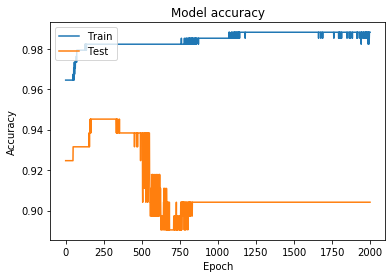

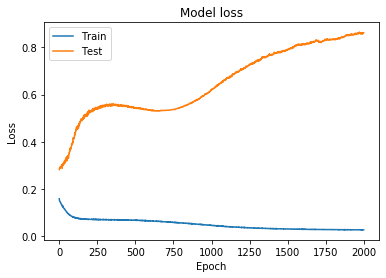

In [205]:

X = df.iloc[:,:-1]
Y = df.iloc[:,-1]
print(X)
print(Y)


def create_model_null():
    model = Sequential()
    model.add(Dense(144,input_dim = 48, activation = 'sigmoid'))
    model.add(Dense(1,activation = 'sigmoid'))
    return model


'''
Model just with backpropagation
'''
def BP(X,Y):
    n = create_model_null()
    n.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
    history = n.fit(X, Y, validation_split=0.3, epochs=2000, batch_size=20, verbose=1, shuffle = True)
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
BP(X,Y)

In [202]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1) 
# 70% training and 30% test
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.952054794520548
